In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [179]:
df_all_stats = pd.read_csv('nba_player_stats.csv')
df_all_stats.head()

,Unnamed: 0,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,31.0,943.0,182.0,369.0,13.0,40.0,112.0,187.0,...,73.0,489.0,0.493,0.325,0.599,30.4,15.8,10.8,1.0,589
1,Steven Adams,2012-13,32.0,749.0,100.0,175.0,0.0,0.0,31.0,70.0,...,52.0,231.0,0.571,NaN,0.443,23.4,7.2,6.3,0.6,511
2,Bam Adebayo,2016-17,38.0,1145.0,170.0,284.0,0.0,0.0,154.0,236.0,...,99.0,494.0,0.599,NaN,0.653,30.1,13.0,8.0,0.8,973
3,Jarrett Allen,2016-17,33.0,1061.0,179.0,316.0,0.0,7.0,84.0,149.0,...,68.0,442.0,0.566,0.000,0.564,32.2,13.4,8.4,0.8,904
4,Carmelo Anthony,2002-03,35.0,1274.0,277.0,612.0,56.0,166.0,168.0,238.0,...,77.0,778.0,0.453,0.337,0.706,36.4,22.2,10.0,2.2,876


In [3]:
def f_PTS_to_float(item):
    """Converts string to floats
    
    Args:
        item (String): String representation of fantasy points
        
    Return
        f_item (float): float representation of fantasy points
    """
    if type(item) == str:
        f_item = float(''.join((item).split(',')))
    
    else:
        f_item = item
    
    return(f_item)

In [4]:
df_all_stats.rename({'Unnamed: 0':'Name'}, axis=1, inplace=True)
df_all_stats.fillna(0.0,inplace=True)

df_all_stats['f_PTS'] = df_all_stats['f_PTS'].map(f_PTS_to_float)

df_stats_scaled = pd.DataFrame()
non_scalable = ['Name','season','f_PTS']
for feat in df_all_stats.columns:
    if feat not in non_scalable:
        df_stats_scaled[f'{feat}'] = df_all_stats[feat] / df_all_stats[feat].std()
    else:
        df_stats_scaled[f'{feat}'] = df_all_stats[feat]
    
df_stats_scaled.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,6.618237,3.554693,3.935198,3.741928,0.485318,0.579101,2.784598,3.517486,...,2.598504,3.636444,7.233723,2.798675,6.307875,4.360287,4.269898,5.242937,0.676669,589.0
1,Steven Adams,2012-13,6.831729,2.823399,2.162197,1.774627,0.000000,0.000000,0.770737,1.316706,...,1.850989,1.717829,8.378206,0.000000,4.665089,3.356273,1.945776,3.058380,0.406001,511.0
2,Bam Adebayo,2016-17,8.112678,4.316144,3.675735,2.879966,0.000000,0.000000,3.828822,4.439180,...,3.523998,3.673627,8.789046,0.000000,6.876531,4.317258,3.513207,3.883657,0.541335,973.0
3,Jarrett Allen,2016-17,7.045220,3.999501,3.870332,3.204469,0.000000,0.101343,2.088449,2.802703,...,2.420524,3.286929,8.304842,0.000000,5.939301,4.618462,3.621306,4.077840,0.541335,904.0
4,Carmelo Anthony,2002-03,7.472203,4.802416,5.989285,6.206124,2.090603,2.403267,4.176897,4.476800,...,2.740887,5.785590,6.646808,2.902011,7.434657,5.220870,5.999477,4.854571,1.488671,876.0


In [5]:
def split_features_target(df_stats_scaled):
    """ creates target and feature groups
    
    Args:
        df_stats_scaled (pd.DataFrame): Scaled stats of players
        
    Returns:
        features (pd.DataFrame): only features to test with
        target (pd.DataFrame): target feature
    """
    
    features = df_stats_scaled.drop(['f_PTS','season'], axis = 1)
    target = df_stats_scaled[['f_PTS']]
    
    return(features,target)

In [6]:
def plot_test_alpha(df_stats_scaled, lasso_type='Lasso', start=0.01, end=1, step=0.01):
    """ plots multiple alphas to find optimal choice
    
    Args:
        df_stats_scaled (pd.DataFrame): Dataframe of college stats and fantasy points
                                        one player per row
        lasso_type (String): type of lasso regression to run
                                        options: 'Lasso', 'Lars'
        start (float): first alpha value
        end (float): last alpha value
        step (float): step size between alpha values
    Returns:
        alpha_plots (plt.Figure): 4 plots of the various alpha values tests
    """
    
    features, target = split_features_target(df_stats_scaled)
    
    x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)
    
    x_train.drop(['Name'], axis = 1, inplace=True)
    x_test.drop(['Name'], axis = 1, inplace=True)
    
    alphas = []
    r2_scores_train = []
    RMSE_train = []
    r2_scores_test = []
    RMSE_test = []
    
    for a in np.arange(start,end,step):

        if lasso_type == 'Lasso':
            lasso = Lasso(alpha = a, normalize = True).fit(X = x_train, y = y_train)
        elif lasso_type == 'Lars':
            lasso = LassoLars(alpha = a, normalize = True).fit(X = x_train, y = y_train)

        alphas.append(a)

        r2_scores_train.append(r2_score(y_train, lasso.predict(x_train)))
        RMSE_train.append(np.sqrt(mean_squared_error(y_train, lasso.predict(x_train))))

        r2_scores_test.append(r2_score(y_test, lasso.predict(x_test)))
        RMSE_test.append(np.sqrt(mean_squared_error(y_test, lasso.predict(x_test))))
    
    
    plt.figure(1,figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(alphas, r2_scores_train, 'b-')
    plt.title('Train R^2 Values')
    plt.xlabel('Alpha Values')

    plt.subplot(222)
    plt.plot(alphas, RMSE_train, 'b-')
    plt.title('Train Root Mean Square Error Values')
    plt.xlabel('Alpha Values')

    plt.subplot(223)
    plt.plot(alphas, r2_scores_test, 'r-')
    plt.title('Test R^2 Values')
    plt.xlabel('Alpha Values')

    plt.subplot(224)
    plt.plot(alphas, RMSE_test, 'r-')
    plt.title('Test Root Mean Square Error Values')
    plt.xlabel('Alpha Values')

    plt.subplots_adjust(top=0.92, bottom=0.01, left=0.10, right=0.95, hspace=0.50,
                        wspace=0.35)

    plt.figure(1)

    plt.suptitle(f'{lasso_type}')
    alpha_plots = plt.figure(1)
    plt.show()
    
    return(alpha_plots)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


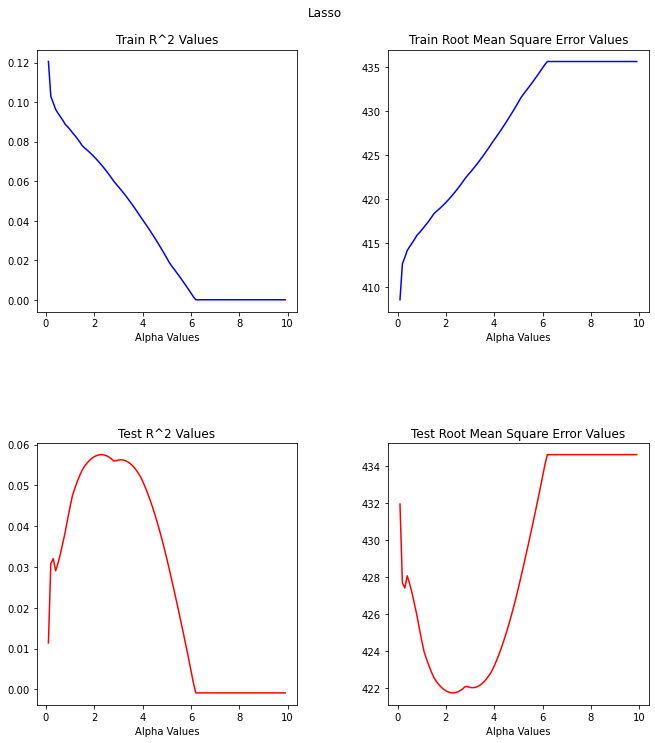

In [7]:
alpha_plots = plot_test_alpha(df_stats_scaled, lasso_type='Lasso', start=0.1, end=10, step=0.1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


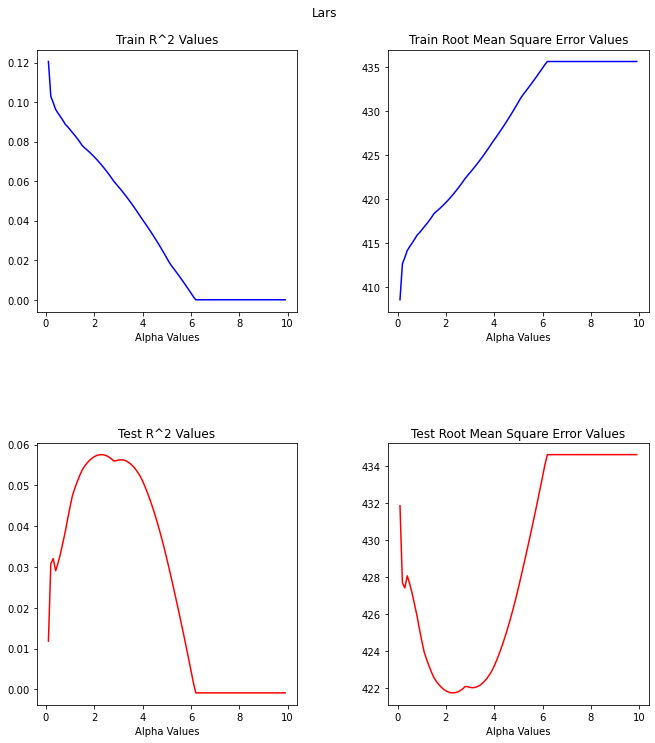

In [8]:
alpha_plots = plot_test_alpha(df_stats_scaled, lasso_type='Lars', start=0.1, end=10, step=0.1)

In [9]:
def get_results(df_stats_scaled, lasso_type='Lasso', alpha=2):
    """ gets result coefficients and accuracy indicators
    
    Args:
        df_stats_scaled (pd.DataFrame): Dataframe of college stats and fantasy points
                                        one player per row
        lasso_type (String): type of lasso regression to run
                                        options: 'Lasso', 'Lars', 'CV', 'LarsCV'
        alpha (float): alpha for lasso regression (not needed for CV/LarsCV)
        
    Returns:
        results (pd.DataFrame): resulting coefficients from lasso regression
        r2 (float): see r2_score for sklearn
        mse (float): see mean_squared_error for sklearn
        alpha_result (float): see.alpha_ from sklearn
                                    only for CV/LarsCV
    """

    features, target = split_features_target(df_stats_scaled)
    
    x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42)
    
    x_train.drop(['Name'], axis = 1, inplace=True)
    x_test.drop(['Name'], axis = 1, inplace=True)

    if lasso_type == 'Lasso':
        lasso = Lasso(alpha = alpha, normalize = True).fit(X = x_train, y = y_train)
        alpha_result = alpha
        
    elif lasso_type == 'Lars':
        lasso = LassoLars(alpha = alpha, normalize = True).fit(X = x_train, y = y_train)
        alpha_result = alpha
        
    elif lasso_type == 'CV':
        lasso = LassoCV(normalize = True, cv=10).fit(X = x_train, y = y_train)
        alpha_result = lasso.alpha_
        
    elif lasso_type == 'LarsCV':
        lasso = LassoLarsCV(normalize = True, cv=10).fit(X = x_train, y = y_train)
        alpha_result = lasso.alpha_
        
    results = pd.DataFrame(x_train.columns.tolist())
    results['coef'] = lasso.coef_
    results = results.where(results['coef'] != 0).dropna()
    
    r2 = r2_score(y_test, lasso.predict(x_test))
    mse = mean_squared_error(y_test, lasso.predict(x_test))
    
    
    return(r2, mse, results, alpha_result)

In [10]:
r2_cv, mse_cv, results_cv, alpha_cv = get_results(df_stats_scaled, lasso_type='CV')

print(f'LassoCV alpha: {alpha_cv}')

r2_lasso, mse_lasso, results_lasso, alpha = get_results(df_stats_scaled, lasso_type='Lasso', alpha=alpha_cv)

print(f'Lasso \n r2: {r2_lasso}, mse: {mse_lasso}')
results_lasso

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV alpha: 1.6419945340518851
Lasso 
 r2: 0.05506132520617768, mse: 178346.4494267225


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,55.602946
6,ft,25.068174
15,pts,37.697842
18,ft_pct,14.738829


In [113]:
r2_lasso, mse_lasso, results_all_lasso, alpha = get_results(df_stats_scaled, lasso_type='Lasso', alpha=2.25)
print(f'Lasso \n r2: {r2_lasso}, mse: {mse_lasso}')
results_all_lasso

Lasso 
 r2: 0.05752869134523708, mse: 177880.7620735903


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,45.418165
6,ft,19.039634
15,pts,37.819512
18,ft_pct,7.198134


In [114]:
r2_larscv, mse_larscv, results_larscv, alpha_larscv = get_results(df_stats_scaled, lasso_type='LarsCV')
print(f'LassoLarsCV: {alpha_larscv}')

r2_lasso, mse_lasso, results_lasso, alpha = get_results(df_stats_scaled, lasso_type='Lars', alpha=alpha_larscv)

print(f'Lasso \n r2: {r2_lasso}, mse: {mse_lasso}')
results_lasso

LassoLarsCV: 1.608235485542412
Lasso 
 r2: 0.05479893848840789, mse: 178395.97194150495


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,56.167799
6,ft,25.397124
15,pts,37.695673
18,ft_pct,15.157881


In [115]:
r2_lasso, mse_lasso, results_all_lars, alpha = get_results(df_stats_scaled, lasso_type='Lars', alpha=2.25)
print(f'Lasso \n r2: {r2_lasso}, mse: {mse_lasso}')
results_all_lars

Lasso 
 r2: 0.057530217041506515, mse: 177880.47411573675


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,45.417675
6,ft,19.035277
15,pts,37.822970
18,ft_pct,7.198405


# Refine by limiting years of college data

In [14]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

In [15]:
def get_nba_player_html(year):
    """ Web scrapping https://www.basketball-reference.com/leagues/NBA_2021_totals.html
        to retrieve NBA player college statistic
        
        Args:
            year (int) : Represent year in yyyy format (e.g. 2021)
        
        Return:
            html_player (html) : raw html webscrapped from basketball-reference.com
    """
    nba_player = f'https://www.basketball-reference.com/leagues/NBA_{year}_totals.html'
    html_player = requests.get(nba_player)
    status = html_player.status_code
    
    # If page load correctly
    if status == 200:
        return html_player.text

In [16]:
def extract_nba_player(html_player):
    """ Extract the NBA player from the crawled webpage in order to retrieve stat
    
        Args:
            html_player (String) : Represent the crawled league webpage
            
        Return:
            df_player (DataFrame) : Represent list of player and corresponding stat URL
    """
    base_url = 'https://www.basketball-reference.com'
    soup = BeautifulSoup(html_player)
    df_player = pd.DataFrame()
    
    # Find all player with stat URL
    for player in soup.find_all('td', {'data-stat': 'player'}):
        link = player.find_all('a')[0]
        
        # Construct Dict that contain Player Name and URL to player stat
        dict_player = {'player_name' : player.text,
                      'url' : base_url + link.attrs['href']}
        
        df_player = df_player.append(dict_player, ignore_index=True)
        
    
    # Drop any duplicate and retain the first entries
    df_player.drop_duplicates(subset='player_name', keep='first', inplace=True)
        
    return df_player

In [17]:
def get_nba_collegestat(player_url):
    """ Web Scrapping https://www.basketball-reference.com/players and retrive player's
        college statistic
        
        Args:
            player_url (String) : Represent URL that contain player stat
            
        Return:
            html_stat (String) : Represent the stat for all NBA player in HTML
    """
    html_stat = requests.get(player_url)
    status = html_stat.status_code
    
    # If page load correctly
    if status == 200:
        return html_stat.text

In [18]:
def extract_nba_collegestat(html_stat):
    """ Extract college stat from NBA player
    
        Args:
            html_stat (String) : Represent the crawled player stat webpage
            
        Return:
            dict_stat (Dictionary) : Represent the player college stat
    """
    soup = BeautifulSoup(html_stat)
    
    # Clean up hidden scripts
    stat_wcomment = soup.find_all('div', {'id':'all_all_college_stats'})
    
    if not stat_wcomment:
        dict_stat = {}
        return dict_stat
    else:
        str_stat = str(stat_wcomment[0]).replace('<!--','').replace('-->','')
    
        soup = BeautifulSoup(str_stat)
        stat_body = soup.find('tbody')

        # Initalize Dict
        dict_stat = {}

        # Add year
        for year in stat_body.find_all('th'):
            # Get Year and Value
            key = year.get('data-stat')
            value = year.text

            if key not in dict_stat.keys():
                dict_stat[key] = [value]
            else:
                dict_stat[key] = dict_stat[key] + [value]


        # Add Stat Information
        for stat in stat_body.find_all('td'):
            # Get Metric and Value
            key = stat.get('data-stat')
            value = stat.text

            if key not in dict_stat.keys():
                dict_stat[key] = [value]
            else:
                dict_stat[key] = dict_stat[key] + [value]
    
        return dict_stat

In [19]:
def build_nba_college(df_player):
    """ Build the NBA college Data given list of player and URL
    
        Args:
            df_player (DataFrame) : Represent list of Player and corresponding stat URL
            
        Return:
            df_nba_collegestat (DataFrame) : Represent the NBA Player college stat
    """
    df_nba_collegestat = pd.DataFrame()
    
    # iterate through each player and url in dataframe
    for idx, row in df_player.iterrows():
        player = row['player_name']
        url = row['url']
        
        # get player stats as dictionary
        player_stat_url = get_nba_collegestat(url)
        dict_player_stat = extract_nba_collegestat(player_stat_url)
        
        # convert dictionary to dataframe
        df_player_temp = pd.DataFrame(dict_player_stat)
        df_player_temp['player_name'] = player
        
        # adds player dataframe to full stats dataframe
        df_nba_collegestat = df_nba_collegestat.append(df_player_temp)
        
    return df_nba_collegestat 

In [20]:
def get_multiple_years(df_college_stats):
    """ Gets dataframe of players who played multiple years

        Args:
            df_college_stats (pd.DataFrame): all college player statistics
        
        Returns:
            df_multiples (pd.GroupBy): all statistics of multiple year players
                                            grouped by player
    """
    # removes duplicates and groups them by player
    x = df_college_stats.duplicated(['player_name'],keep=False)
    df_multiples = df_college_stats[x].groupby('player_name',sort=False)
    
    return(df_multiples)

In [21]:
def avg_college_stats(df_multiples):
    """ Gets average of college career stats
    
    Args:
        df_multiples (pd.GroupBy): all statistics of multiple year players
                                            grouped by player
    
    Returns:
        df_college_avg (pd.DataFrame): average of each multi-year player's college career
    """
    # the columns names of averagable stats
    mean_column_list = list(df_college_stats.columns)[3:-1]
    
    # initalize list to collect each Series
    all_college_stats = []
    
    # iterates through players that have multi-year college careers
    for player in df_multiples:
        name, stats = player[0], player[1]
        
        # creates series of just averagable stats
        stats_to_avg = stats.loc[:,mean_column_list]
        
        # removes potential errors
        stats_to_avg.replace('',0.0,inplace=True)
        
        # converts strings to floats
        for column in stats_to_avg.columns:
            for idx in stats_to_avg[column].index: 
                stats_to_avg[column][idx] = float(stats_to_avg[column][idx])
        
        # averages college stats
        avg_stats = round(stats_to_avg.mean(axis=0), 2)

        # creates new career duration data
        career_season = stats['season'].iloc[0][:4]+'-'+stats['season'].iloc[-1][:4]
        
        # adds career duration and player name to series
        avg_stats['season'] = career_season
        avg_stats['player_name'] = name
        
        # appends series to list
        all_college_stats.append(avg_stats)
        
    # builds dataframe from list
    df_college_avg = pd.DataFrame(all_college_stats)
    
    return(df_college_avg)

In [22]:
def build_final_college(df_college_avg, df_college_stats):
    """ Combines dataframes of single year players with avg multi-year players
    
    Args:
        df_college_avg (pd.Dataframe): averaged stats of multi-year players
        df_college_stats (pd.DataFrame): stats for all players, each row a year
        
    Returns:
        df_final_college (pd.DataFrame): all college stats, one player per row
                                            multi-year stats averaged
    """
    # get multi-year players
    multiples = df_college_stats.duplicated(['player_name'],keep=False)
    
    # keeps just single year players
    df_college = df_college_stats[~multiples].drop(['college_id','age'],axis=1)
    
    # append averaged multi-years to dataframe of single years
    df_final_college = df_college.append(df_college_avg)
    
    # cleans indicies
    df_final_college.reset_index(inplace=True)
    df_final_college.drop('index',axis=1,inplace=True)
    
    return(df_final_college)

In [23]:
html_player = get_nba_player_html(2021)
df_player = extract_nba_player(html_player)

In [24]:
url = df_player.loc[0,'url']
html_stat = get_nba_collegestat(url)
extract_nba_collegestat(html_stat)

{'season': ['2019-20'],
 'age': ['20'],
 'college_id': ['MEMPHIS'],
 'g': ['31'],
 'mp': ['943'],
 'fg': ['182'],
 'fga': ['369'],
 'fg3': ['13'],
 'fg3a': ['40'],
 'ft': ['112'],
 'fta': ['187'],
 'orb': ['93'],
 'trb': ['334'],
 'ast': ['30'],
 'stl': ['34'],
 'blk': ['58'],
 'tov': ['87'],
 'pf': ['73'],
 'pts': ['489'],
 'fg_pct': ['.493'],
 'fg3_pct': ['.325'],
 'ft_pct': ['.599'],
 'mp_per_g': ['30.4'],
 'pts_per_g': ['15.8'],
 'trb_per_g': ['10.8'],
 'ast_per_g': ['1.0']}

In [180]:
df_college_stats = build_nba_college(df_player)
df_college_stats.head()

,season,age,college_id,g,mp,fg,fga,fg3,fg3a,ft,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,player_name
0,2019-20,20,MEMPHIS,31,943,182,369,13,40,112,...,73,489,.493,.325,.599,30.4,15.8,10.8,1.0,Precious Achiuwa
0,2014-15,18,STBONNY,22,714,61,158,34,105,65,...,47,221,.386,.324,.783,32.5,10.0,2.5,4.5,Jaylen Adams
1,2015-16,19,STBONNY,30,1125,150,337,84,192,153,...,80,537,.445,.438,.874,37.5,17.9,3.7,5.0,Jaylen Adams
2,2016-17,20,STBONNY,30,1123,168,401,77,216,206,...,84,619,.419,.356,.821,37.4,20.6,3.7,6.5,Jaylen Adams
3,2017-18,21,STBONNY,28,1036,153,350,75,172,154,...,80,535,.437,.436,.851,37.0,19.1,3.4,5.2,Jaylen Adams


In [181]:
df_multiples = get_multiple_years(df_college_stats)
df_multiples.head()

,season,age,college_id,g,mp,fg,fga,fg3,fg3a,ft,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,player_name
0,2014-15,18,STBONNY,22,714,61,158,34,105,65,...,47,221,.386,.324,.783,32.5,10.0,2.5,4.5,Jaylen Adams
1,2015-16,19,STBONNY,30,1125,150,337,84,192,153,...,80,537,.445,.438,.874,37.5,17.9,3.7,5.0,Jaylen Adams
2,2016-17,20,STBONNY,30,1123,168,401,77,216,206,...,84,619,.419,.356,.821,37.4,20.6,3.7,6.5,Jaylen Adams
3,2017-18,21,STBONNY,28,1036,153,350,75,172,154,...,80,535,.437,.436,.851,37.0,19.1,3.4,5.2,Jaylen Adams
0,2004-05,19,TEXAS,16,355,57,86,0,0,44,...,,158,.663,,.657,22.2,9.9,5.9,0.9,LaMarcus Aldridge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2019-20,20,MISSST,31,1025,136,275,30,70,50,...,58,352,.495,.429,.641,33.1,11.4,6.5,1.3,Robert Woodard II
0,2013-14,21,UTAH,33,1202,174,310,12,54,153,...,61,513,.561,.222,.793,36.4,15.5,6.8,5.3,Delon Wright
1,2014-15,22,UTAH,35,1165,165,324,26,73,153,...,49,509,.509,.356,.836,33.3,14.5,4.9,5.1,Delon Wright
0,2011-12,19,INDIANA,36,1025,200,321,0,0,163,...,97,563,.623,,.755,28.5,15.6,6.6,1.3,Cody Zeller


In [182]:
df_college_avg = avg_college_stats(df_multiples)
df_college_avg.head()

<ipython-input-21-765b74d60e64>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_to_avg[column][idx] = float(stats_to_avg[column][idx])


,g,mp,fg,fga,fg3,fg3a,ft,fta,orb,trb,...,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,season,player_name
0,27.50,999.50,133.00,311.50,67.50,171.25,144.50,172.50,14.75,93.0,...,478.00,0.42,0.39,0.83,36.10,16.90,3.32,5.30,2014-2017,Jaylen Adams
1,26.50,801.00,138.00,235.50,0.00,0.00,80.50,124.00,0.00,217.0,...,356.50,0.62,0.00,0.65,27.95,12.45,7.55,0.70,2004-2005,LaMarcus Aldridge
2,32.67,922.67,133.33,319.00,70.00,188.33,77.00,94.67,10.33,120.0,...,413.67,0.42,0.37,0.79,28.33,12.70,3.70,2.27,2017-2019,Ty-Shon Alexander
3,33.50,1003.00,157.00,338.50,58.00,151.50,79.00,103.50,19.50,133.0,...,451.00,0.46,0.38,0.75,29.85,13.45,3.95,2.75,2017-2018,Nickeil Alexander-Walker
4,35.50,991.25,151.50,352.25,72.75,191.50,123.25,147.75,19.00,112.5,...,499.00,0.43,0.37,0.84,27.75,14.00,3.15,3.00,2014-2017,Grayson Allen


In [183]:
df_final_college = build_final_college(df_college_avg, df_college_stats)
df_final_college.head()

,season,g,mp,fg,fga,fg3,fg3a,ft,fta,orb,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,player_name
0,2019-20,31,943,182,369,13,40,112,187,93,...,73,489,.493,.325,.599,30.4,15.8,10.8,1.0,Precious Achiuwa
1,2012-13,32,749,100,175,0,0,31,70,90,...,52,231,.571,,.443,23.4,7.2,6.3,0.6,Steven Adams
2,2016-17,38,1145,170,284,0,0,154,236,118,...,99,494,.599,,.653,30.1,13.0,8.0,0.8,Bam Adebayo
3,2016-17,33,1061,179,316,0,7,84,149,100,...,68,442,.566,.000,.564,32.2,13.4,8.4,0.8,Jarrett Allen
4,2017-18,29,438,58,101,2,15,33,64,24,...,66,151,.574,.133,.516,15.1,5.2,2.9,0.4,Kostas Antetokounmpo


In [31]:
def get_fantasy_stat(year):
    """ Get all NBA Player Stat from https://www.fantasypros.com/nba/stats/overall.php
    
        Args:
            year (int) : Represent year in yyyy which NBA data will be extracted 
            
        Return:
            nba_html (string) : Represent the NBA stat in HTML Representation
    """
    nba_url = f'https://www.fantasypros.com/nba/stats/overall.php?year={year}'
    nba_html = requests.get(nba_url)
    status = nba_html.status_code
    
    # If page load correctly
    if status == 200:
        return nba_html.text

In [32]:
def extract_nba_stat(nba_html):
    """ Extract NBA Stat from the fantasypros website
    
        Args:
            nba_html (string) : Represent the NBA stat in HTML Representation
            
        Return:
            df_nba_stat (DataFrame) : Represent the dataframe contain NBA stat
    
    """
    dict_nba_stat = {'Player' : [], 
                    'PTS' : [],
                    'REB' : [],
                    'AST' : [],
                    'BLK' : [],
                    'STL' : [],
                    'FG%' : [],
                    'FT%' : [],
                    '3PM' : [],
                    'TO' : [],
                    'GP' : [],
                    'MIN' : [],
                    'FTM' : [],
                    '2PM' :[],
                    'A/TO' : [],
                    'PF':[]}
    df_nba_stat = pd.DataFrame(dict_nba_stat)
    soup = BeautifulSoup(nba_html)
    
    # Extract all Information
    for row in soup.find('tbody').find_all('tr'):
        arr = np.array([i.text for i in row.find_all('td')])
        
        df_nba_stat = df_nba_stat.append(pd.DataFrame(arr.reshape(1,-1), columns=list(df_nba_stat)), ignore_index=True)
        
    return df_nba_stat

In [184]:
nba_html = get_fantasy_stat(2021)
df_nba_stat = extract_nba_stat(nba_html)

In [185]:
contain_within = ['2019-20', '2016-17', '2017-18', '2018-19', '2017-2019', '2017-2018', '2016-2019' 
                  ,'2016-2017', '2018-2019', '2014-2018', '2016-2018', '2013-2017']

df_college_stats = pd.DataFrame()

for season in contain_within:
    filter_df = df_final_college[df_final_college['season'].str.contains(season)==True]
    df_college_stats = df_college_stats.append(filter_df, ignore_index=True)


In [35]:
def get_fantasy_points(df_nba_stat, df_final_college):
    """ Gets fantasy points for only players with college stats
    
    Args: 
        df_nba_stat (pd.Dataframe): Dataframe contains NBA stat and fantasy points
        df_final_college (pd.Dataframe): all college stats, one player per row
        
    Returns:
        fantasy_dict (Dictionary): Player name as keys, fantasy points as values
    """
    # initalize dictionary to collect fantasy points
    fantasy_dict = {}
    
    # itterates through NBA stat dataframe
    for idx in df_nba_stat.index:
        
        # collects player name as keys and fantasy points as values
        name = df_nba_stat.loc[idx,'Player'].split('(')[0].strip()
        points = df_nba_stat.loc[idx,'PTS']
    
        # doesn't include players missing college data
        if name in list(df_final_college['player_name']):
            fantasy_dict[name] = points
    
    return(fantasy_dict)

In [186]:
fantasy_dict = get_fantasy_points(df_nba_stat, df_college_stats)

In [37]:
def build_all_stats(fantasy_dict, df_final_college):
    """ Builds dataframe of all college stats and fantasy points
    
    Args:
        fantasy_dict (Dictionary): Player name as keys, fantasy points as values
        df_final_college (pd.Dataframe): all college stats, one player per row
        
    Returns:
        df_all_stats (pd.Dataframe): Dataframe of college stats and fantasy points
                                        one player per row
    """

    df_college_temp = df_final_college.set_index('player_name')
    
    # drop players that don't have fantasy point stats
    for name in df_college_temp.index:
        if name not in list(fantasy_dict.keys()):
            df_college_temp = df_college_temp.drop(name,axis=0)
    
    # initalize list for Series of player
    final_stats_list = []
    
    # itterate through college data
    for name in df_college_temp.index:
        
        # create series of player stats and add fantasy points
        player_series = df_college_temp.loc[name,:]
        player_series['f_PTS'] = fantasy_dict[name]
        
        # append to list of player series
        final_stats_list.append(player_series)
    
    # assemble dataframe from list
    df_all_stats = pd.DataFrame(final_stats_list)
    
    return(df_all_stats)

In [187]:
df_stats_recent = build_all_stats(fantasy_dict, df_college_stats)
df_stats_recent.replace('','NaN',inplace=True)
df_stats_recent['f_PTS'] = df_stats_recent['f_PTS'].map(f_PTS_to_float)
df_stats_recent.fillna(0.0,inplace=True)
df_stats_recent.head()

,season,g,mp,fg,fga,fg3,fg3a,ft,fta,orb,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
Precious Achiuwa,2019-20,31,943,182,369,13,40,112,187,93,...,73,489,.493,.325,.599,30.4,15.8,10.8,1.0,664.0
Cole Anthony,2019-20,22,768,131,345,49,141,96,128,10,...,64,407,.380,.348,.750,34.9,18.5,5.7,4.0,1062.0
Vernon Carey Jr.,2019-20,31,772,199,345,8,21,146,218,83,...,85,552,.577,.381,.670,24.9,17.8,8.8,1.0,20.0
Anthony Edwards,2019-20,32,1057,203,505,72,245,132,171,24,...,70,610,.402,.294,.772,33.0,19.1,5.2,2.8,1533.0
Josh Green,2019-20,30,926,122,288,30,83,85,109,39,...,73,359,.424,.361,.780,30.9,12.0,4.6,2.6,319.0


In [104]:
def scale_stats(df, non_scalable):
    """creates a scaled version of the dataframe
    
    Args:
        df (pd.DataFrame): dataframe to be scaled
        non_scalable (List of Strings): column labels that can't be scaled
    
    Returns:
        df_scaled (pd.DataFrame): scaled dataframe
    """

    df_scaled = pd.DataFrame()
    
    for feat in df.columns:
        if feat not in non_scalable:
            df = df.astype({f'{feat}': 'float'})
            df_scaled[f'{feat}'] = df[feat] / df[feat].std()
        else:
            df_scaled[f'{feat}'] = df[feat]
            
    return(df_scaled)

In [109]:

non_scalable = ['Name','season','f_PTS']
df_scaled = scale_stats(df_all_stats, non_scalable=non_scalable)
df_scaled.dropna(inplace=True)
df_scaled.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,6.618237,3.554693,3.935198,3.741928,0.485318,0.579101,2.784598,3.517486,...,2.598504,3.636444,7.233723,2.798675,6.307875,4.360287,4.269898,5.242937,0.676669,589.0
1,Steven Adams,2012-13,6.831729,2.823399,2.162197,1.774627,0.000000,0.000000,0.770737,1.316706,...,1.850989,1.717829,8.378206,0.000000,4.665089,3.356273,1.945776,3.058380,0.406001,511.0
2,Bam Adebayo,2016-17,8.112678,4.316144,3.675735,2.879966,0.000000,0.000000,3.828822,4.439180,...,3.523998,3.673627,8.789046,0.000000,6.876531,4.317258,3.513207,3.883657,0.541335,973.0
3,Jarrett Allen,2016-17,7.045220,3.999501,3.870332,3.204469,0.000000,0.101343,2.088449,2.802703,...,2.420524,3.286929,8.304842,0.000000,5.939301,4.618462,3.621306,4.077840,0.541335,904.0
4,Carmelo Anthony,2002-03,7.472203,4.802416,5.989285,6.206124,2.090603,2.403267,4.176897,4.476800,...,2.740887,5.785590,6.646808,2.902011,7.434657,5.220870,5.999477,4.854571,1.488671,876.0


In [111]:

df_recent_scaled = pd.DataFrame()
non_scalable = ['Name','season','f_PTS']

for feat in df_stats_recent.columns:
    if feat not in non_scalable:
        df_stats_recent = df_stats_recent.astype({f'{feat}': 'float'})
        df_stats_recent[f'{feat}'] = pd.to_numeric(df_stats_recent[f'{feat}'], downcast="float")
        df_recent_scaled[f'{feat}'] = df_stats_recent[feat] / df_stats_recent[feat].std()
    else:
        df_recent_scaled[f'{feat}'] = df_stats_recent[feat]
df_recent_scaled.reset_index(inplace=True)
df_recent_scaled.rename(columns={'index':'Name'},inplace=True)
df_recent_scaled.dropna(inplace=True)
df_recent_scaled.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,5.318467,4.235367,3.710539,3.514767,0.464237,0.544076,2.763049,3.527815,...,3.832860,3.437855,6.600478,3.356422,6.843409,6.511870,4.131114,5.310562,0.622349,664.0
1,Cole Anthony,2019-20,3.774396,3.449377,2.670773,3.286164,1.749818,1.917866,2.368327,2.414761,...,3.360316,2.861364,5.087589,3.593954,8.568542,7.475799,4.837063,2.802797,2.489396,1062.0
2,Vernon Carey Jr.,2019-20,5.318467,3.467342,4.057128,3.286164,0.285685,0.285640,3.601831,4.112639,...,4.462919,3.880769,7.725103,3.934760,7.654565,5.333736,4.654039,4.327125,0.622349,20.0
3,Anthony Edwards,2019-20,5.490030,4.747384,4.138678,4.810183,2.571161,3.332463,3.256450,3.225970,...,3.675345,4.288531,5.382134,3.036271,8.819886,7.068807,4.993941,2.556937,1.742577,1533.0
4,Josh Green,2019-20,5.146904,4.159014,2.487284,2.743233,1.071317,1.128957,2.096957,2.056320,...,3.832860,2.523906,5.676679,3.728210,8.911283,6.618974,3.137555,2.261906,1.618107,319.0


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109201.0, tolerance: 2250.65478515625
  model = cd_fast.enet_coordinate_descent(


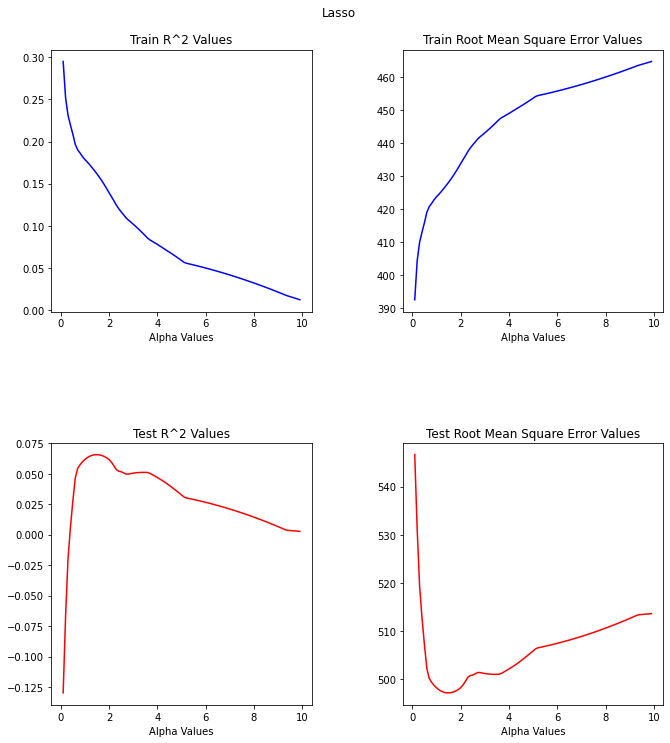

In [69]:
alpha_plots = plot_test_alpha(df_recent_scaled, lasso_type='Lasso', start=0.1, end=10, step=0.1)

In [116]:
r2_cv, mse_cv, results_cv, alpha_cv = get_results(df_stats_scaled, lasso_type='CV')

print(f'LassoCV alpha: {alpha_cv}')

r2_lasso, mse_lasso, results_recent_lasso, alpha = get_results(df_stats_scaled, lasso_type='Lasso', alpha=alpha_cv)

print(f'Lasso \n r2: {r2_lasso}, mse: {mse_lasso}')
results_recent_lasso

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LassoCV alpha: 1.6419945340518851
Lasso 
 r2: 0.05506132520617768, mse: 178346.4494267225


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,55.602946
6,ft,25.068174
15,pts,37.697842
18,ft_pct,14.738829


In [74]:
r2_lasso, mse_lasso, results_lasso, alpha = get_results(df_stats_scaled, lasso_type='Lasso', alpha=1.5)

print(f'Lasso \n r2: {r2_lasso}, mse: {mse_lasso}')
results_lasso

Lasso 
 r2: 0.053800473320911535, mse: 178584.42090888167


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,57.902083
6,ft,26.424617
15,pts,37.906059
18,ft_pct,16.540608
19,mp_per_g,-0.501945


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


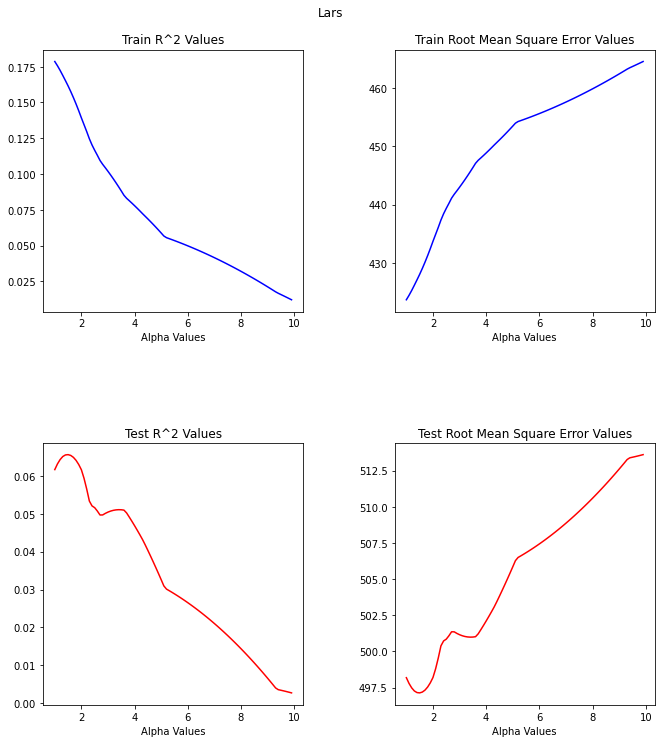

In [78]:
alpha_plots = plot_test_alpha(df_recent_scaled, lasso_type='Lars', start=1, end=10, step=0.1)

In [118]:
r2_larscv, mse_larscv, results_larscv, alpha_larscv = get_results(df_stats_scaled, lasso_type='LarsCV')
print(f'LassoLarsCV: {alpha_larscv}')

r2_lasso, mse_lasso, results_recent_lars, alpha = get_results(df_stats_scaled, lasso_type='Lars', alpha=alpha_larscv)

print(f'LassoLars \n r2: {r2_lasso}, mse: {mse_lasso}')
results_recent_lars

LassoLarsCV: 1.608235485542412
LassoLars 
 r2: 0.05479893848840789, mse: 178395.97194150495


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,56.167799
6,ft,25.397124
15,pts,37.695673
18,ft_pct,15.157881


In [117]:
r2_lasso, mse_lasso, results_lasso, alpha = get_results(df_stats_scaled, lasso_type='Lars', alpha=1.5)

print(f'LassoLars \n r2: {r2_lasso}, mse: {mse_lasso}')
results_lasso

LassoLars 
 r2: 0.05380292879114479, mse: 178583.95746674572


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,coef
0,g,55.602946
6,ft,25.068174
15,pts,37.697842
18,ft_pct,14.738829


# Using above features with Decision Tree Classifier

In [139]:
def assignBucket(f_pts, n_bucket):
    """
    Given a fantasy Point assign a bucket to the player
    
    Args:
        f_pts (int) : Represent the fantasy point for each player
        n_bucket (int) : Represent the range of integer of each buckets
    
    Return:
        bucket (string) : Represent the assigned bucket of the player
    """
    # Get the bucket range
    remainder = f_pts % n_bucket
    
    if remainder == 0:
        # Assign previous bucket
        
        if f_pts == 0:
            return f'0 f_pts'
        
        floor = f_pts - n_bucket
        ceiling = f_pts
    else:
        # Assign the current bucket
        floor = f_pts - remainder
        ceiling = floor + n_bucket
        
    return f'{floor} < f_pts <= {ceiling}'

In [112]:
df_scaled.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,6.618237,3.554693,3.935198,3.741928,0.485318,0.579101,2.784598,3.517486,...,2.598504,3.636444,7.233723,2.798675,6.307875,4.360287,4.269898,5.242937,0.676669,589.0
1,Steven Adams,2012-13,6.831729,2.823399,2.162197,1.774627,0.000000,0.000000,0.770737,1.316706,...,1.850989,1.717829,8.378206,0.000000,4.665089,3.356273,1.945776,3.058380,0.406001,511.0
2,Bam Adebayo,2016-17,8.112678,4.316144,3.675735,2.879966,0.000000,0.000000,3.828822,4.439180,...,3.523998,3.673627,8.789046,0.000000,6.876531,4.317258,3.513207,3.883657,0.541335,973.0
3,Jarrett Allen,2016-17,7.045220,3.999501,3.870332,3.204469,0.000000,0.101343,2.088449,2.802703,...,2.420524,3.286929,8.304842,0.000000,5.939301,4.618462,3.621306,4.077840,0.541335,904.0
4,Carmelo Anthony,2002-03,7.472203,4.802416,5.989285,6.206124,2.090603,2.403267,4.176897,4.476800,...,2.740887,5.785590,6.646808,2.902011,7.434657,5.220870,5.999477,4.854571,1.488671,876.0


In [135]:
print(f' All Lasso: {list(results_all_lasso[0])}, \n All Lars: {list(results_all_lars[0])} ,\
      \n Recent Lasso: {list(results_recent_lasso[0])}, \n Recent Lars: {list(results_recent_lars[0])}')
x_feat_list = list(results_all_lasso[0])

 All Lasso: ['g', 'ft', 'pts', 'ft_pct'], 
 All Lars: ['g', 'ft', 'pts', 'ft_pct'] ,      
 Recent Lasso: ['g', 'ft', 'pts', 'ft_pct'], 
 Recent Lars: ['g', 'ft', 'pts', 'ft_pct']


In [137]:


# Replace All empty entries with Nan and drop the row
df_scaled.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_scaled.dropna(subset=x_feat_list, how='any', inplace=True)

df_scaled.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,6.618237,3.554693,3.935198,3.741928,0.485318,0.579101,2.784598,3.517486,...,2.598504,3.636444,7.233723,2.798675,6.307875,4.360287,4.269898,5.242937,0.676669,589.0
1,Steven Adams,2012-13,6.831729,2.823399,2.162197,1.774627,0.000000,0.000000,0.770737,1.316706,...,1.850989,1.717829,8.378206,0.000000,4.665089,3.356273,1.945776,3.058380,0.406001,511.0
2,Bam Adebayo,2016-17,8.112678,4.316144,3.675735,2.879966,0.000000,0.000000,3.828822,4.439180,...,3.523998,3.673627,8.789046,0.000000,6.876531,4.317258,3.513207,3.883657,0.541335,973.0
3,Jarrett Allen,2016-17,7.045220,3.999501,3.870332,3.204469,0.000000,0.101343,2.088449,2.802703,...,2.420524,3.286929,8.304842,0.000000,5.939301,4.618462,3.621306,4.077840,0.541335,904.0
4,Carmelo Anthony,2002-03,7.472203,4.802416,5.989285,6.206124,2.090603,2.403267,4.176897,4.476800,...,2.740887,5.785590,6.646808,2.902011,7.434657,5.220870,5.999477,4.854571,1.488671,876.0


In [210]:
df_scaled_bucket = df_scaled

# Delete all player with zero fantasy point
df_scaled_bucket = df_scaled_bucket[df_scaled_bucket['f_PTS'] != 0].copy()

# Assign Player Fantasy Bucket
df_scaled_bucket['f_PTS_range'] = \
df_scaled_bucket.apply(lambda row : assignBucket(int(row['f_PTS']), 750), axis=1)
list(df_scaled_bucket['f_PTS_range'].unique())

['0 < f_pts <= 750', '750 < f_pts <= 1500', '1500 < f_pts <= 2250']

In [226]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def basketball_classifier(clf, df_stats, x_feat_list, pca_component=2, n_splits=8, stratified=False):
    """ Given basketball player fantasy points with college career stats. Implemented a
        classifier and display confusion matrix with accuracy score
        
    Args:
        clf (Classifier) : Represent SkLearn Classifier 
                           (e.g KNeighborsClassifier, RandomForestClassifier and etc)
        df_stats (pd.DataFrame) : Represent the baskball player statistic
        x_feat_list (np.Array) : Represent the feature which will be used for classification
        pca_component (int) : Represent the output dimension of PCA component
        n_splits (int) : Represent the number of k-fold
        stratified (boolean) : True if using StratifiedKFold to do cross-validation and false
                               otherwise
                               
    Return:
        clf (Classifier) : Represent the trained classifier
    """
    # Extract Important Feature for RandomForest Classifier
    y_feat = 'f_PTS_range'

    x = df_stats.loc[:,x_feat_list].values
    y = df_stats.loc[:,y_feat].values

    # Implemented Principal Component Analysis
    pca = PCA(n_components=pca_component, whiten=True)
    pca.fit(x)
    x_compress = pca.transform(x)
    
    # Name of Classifier
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    
    # Stratified is true then do cross-validation if false then return trained model
    if stratified:
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

        y_pred = np.empty_like(y)
        for train_idx, test_idx in kfold.split(x_compress, y):
            # index to split training / test data
            x_train = x[train_idx, :]
            x_test = x[test_idx, :]
            y_true_train = y[train_idx]

            # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
            clf.fit(x_train, y_true_train)

            # estimate each Basketball player fantasy point bucket for 2021 Season
            y_pred[test_idx] = clf.predict(x_test)
            
            # displaying the title
            plt_title = f'Cross-Validated {clf_name}'
    else:
        # fit and apply KNN to the model
        clf.fit(x_compress, y)
        y_pred = clf.predict(x_compress)
        
        # displaying the title
        plt_title = f'{clf_name} on Basketball Player 2021 Fantasy Points with college career stats'
        
        
    # Build Confusion Matrix
    labels = ['0 < f_pts <= 750','750 < f_pts <= 1500','1500 < f_pts <= 2250']
    conf_mat = confusion_matrix(y_true=y, y_pred=y_pred, labels = labels)                                                           

    # Build up Confusion Matrix GUI
    conf_display = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
    conf_display.plot()

    # Set Size and Styling
    plt.gcf().set_size_inches(30,10)
    plt.title(plt_title)
    plt.grid(False)
    
    print(f'The accuracy rate is at {accuracy_score(y, y_pred)}')
    return clf

The accuracy rate is at 0.8297297297297297


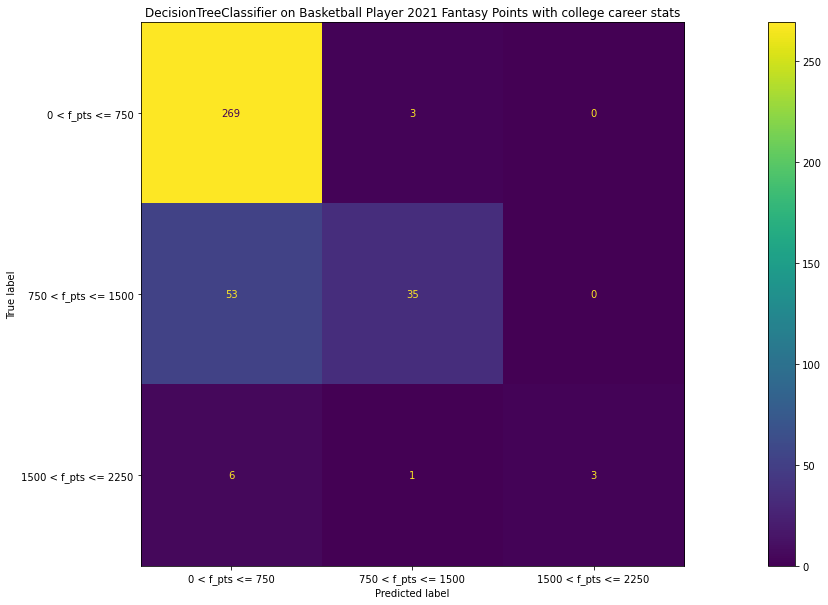

In [227]:
### Initlaize DecisionTreeClassifer with max_depth = 6
dec_basketball = DecisionTreeClassifier(max_depth=6)

# DecisionForestClassifier without Stratified K Fold cross validation
dec_basketball = basketball_classifier(dec_basketball, df_scaled_bucket, x_feat_list ,stratified=False)

The accuracy rate is at 0.827027027027027


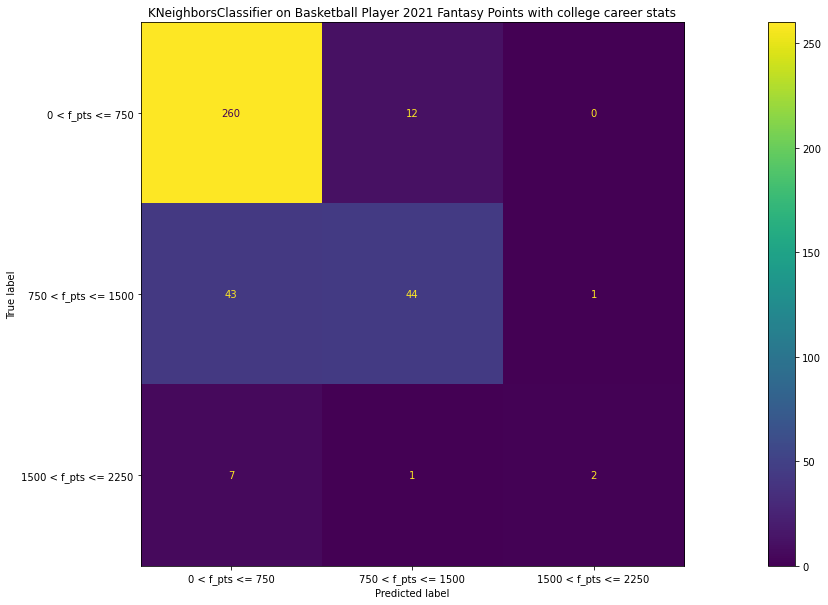

In [231]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)

knn_classifier = basketball_classifier(knn_classifier, df_scaled_bucket, x_feat_list, stratified=False)

## Now using the same feature list but with the recent scaled data

In [199]:

df_stats_recent.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,31,943,182,369,13,40,112,187,...,73,489,.493,.325,.599,30.4,15.8,10.8,1.0,664.0
1,Cole Anthony,2019-20,22,768,131,345,49,141,96,128,...,64,407,.380,.348,.750,34.9,18.5,5.7,4.0,1062.0
2,Vernon Carey Jr.,2019-20,31,772,199,345,8,21,146,218,...,85,552,.577,.381,.670,24.9,17.8,8.8,1.0,20.0
3,Anthony Edwards,2019-20,32,1057,203,505,72,245,132,171,...,70,610,.402,.294,.772,33.0,19.1,5.2,2.8,1533.0
4,Josh Green,2019-20,30,926,122,288,30,83,85,109,...,73,359,.424,.361,.780,30.9,12.0,4.6,2.6,319.0


In [200]:

non_scalable = ['Name','season','f_PTS']
df_recent_scaled = scale_stats(df_stats_recent, non_scalable=non_scalable)
df_recent_scaled.dropna(inplace=True)
df_recent_scaled.head()

,Name,season,g,mp,fg,fga,fg3,fg3a,ft,fta,...,pf,pts,fg_pct,fg3_pct,ft_pct,mp_per_g,pts_per_g,trb_per_g,ast_per_g,f_PTS
0,Precious Achiuwa,2019-20,5.318466,4.235367,3.710539,3.514767,0.464237,0.544076,2.763049,3.527815,...,3.832860,3.437855,6.600480,3.356422,6.843408,6.511871,4.131113,5.310562,0.622349,664.0
1,Cole Anthony,2019-20,3.774395,3.449376,2.670773,3.286164,1.749818,1.917866,2.368328,2.414761,...,3.360316,2.861364,5.087591,3.593954,8.568541,7.475799,4.837063,2.802797,2.489396,1062.0
2,Vernon Carey Jr.,2019-20,5.318466,3.467342,4.057128,3.286164,0.285685,0.285640,3.601832,4.112640,...,4.462920,3.880769,7.725105,3.934760,7.654563,5.333736,4.654039,4.327124,0.622349,20.0
3,Anthony Edwards,2019-20,5.490030,4.747384,4.138678,4.810182,2.571161,3.332463,3.256450,3.225970,...,3.675345,4.288531,5.382136,3.036271,8.819885,7.068807,4.993941,2.556937,1.742577,1533.0
4,Josh Green,2019-20,5.146903,4.159014,2.487285,2.743233,1.071317,1.128957,2.096957,2.056320,...,3.832860,2.523906,5.676680,3.728211,8.911283,6.618974,3.137555,2.261906,1.618107,319.0


In [209]:
df_recent_scaled_bucket = df_recent_scaled

# Delete all player with zero fantasy point
df_recent_scaled_bucket = df_recent_scaled_bucket[df_recent_scaled_bucket['f_PTS'] != 0].copy()

# Assign Player Fantasy Bucket
df_recent_scaled_bucket['f_PTS_range'] = \
df_recent_scaled_bucket.apply(lambda row : assignBucket(int(row['f_PTS']), 750), axis=1)
list(df_recent_scaled_bucket['f_PTS_range'].unique())

['0 < f_pts <= 750', '750 < f_pts <= 1500', '1500 < f_pts <= 2250']

The accuracy rate is at 0.9242424242424242


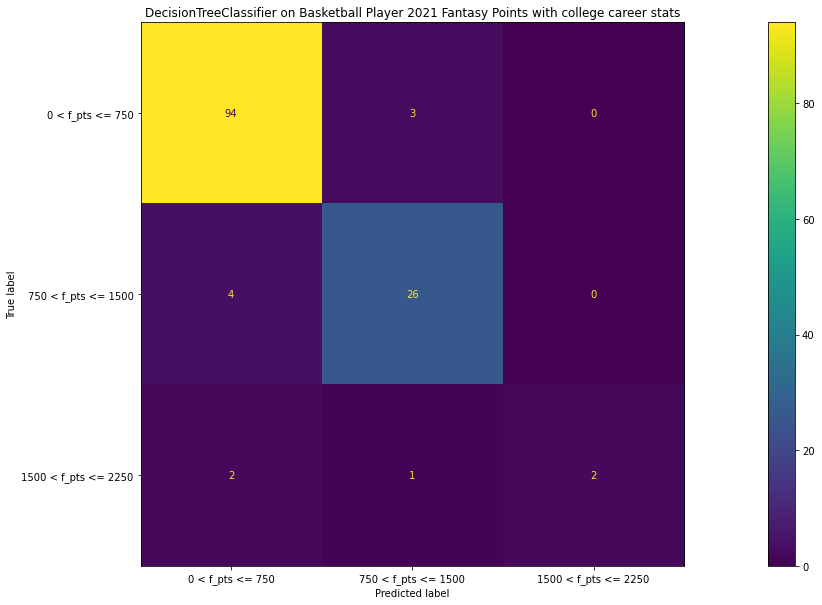

In [232]:
## Initlaize DecisionTreeClassifer with max_depth = 6
dec_basketball = DecisionTreeClassifier(max_depth=6)

# DecisionForestClassifier without Stratified K Fold cross validation
dec_basketball = basketball_classifier(dec_basketball, df_recent_scaled_bucket, x_feat_list ,stratified=False)

The accuracy rate is at 0.7803030303030303


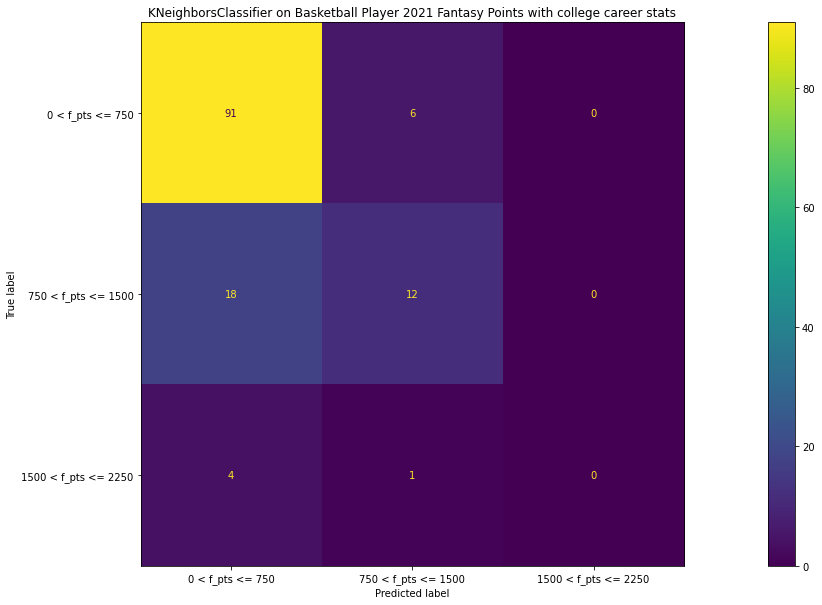

In [233]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)

knn_classifier = basketball_classifier(knn_classifier, df_recent_scaled_bucket, x_feat_list, stratified=False)